In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Change if we want to use all songs instead of just pop
df = pd.read_csv("pop_genres_dataset.csv")

# Make these permanent changes to the dataset??
# Miliseconds to seconds
df["duration_ms"] = df["duration_ms"] / 1000
df = df.rename(columns={"duration_ms": "duration_s"})

df = pd.get_dummies(df, columns=["track_genre"])

df.head()

,artists,track_name,popularity,duration_s,explicit,danceability,energy,key,loudness,mode,...,time_signature,track_genre_cantopop,track_genre_indie-pop,track_genre_j-pop,track_genre_k-pop,track_genre_mandopop,track_genre_pop,track_genre_pop-film,track_genre_power-pop,track_genre_synth-pop
0,my little airport,每次你走的時分,47,183.968,0,0.576,0.505,11,-13.070,0,...,4,True,False,False,False,False,False,False,False,False
1,my little airport,下了兩天雨,44,172.343,0,0.577,0.228,11,-14.684,1,...,4,True,False,False,False,False,False,False,False,False
2,my little airport,詩歌舞街,50,191.308,0,0.641,0.479,4,-15.395,1,...,4,True,False,False,False,False,False,False,False,False
3,my little airport,那陣時不知道,48,148.564,0,0.613,0.210,5,-15.309,1,...,4,True,False,False,False,False,False,False,False,False
4,Eason Chan,無條件,54,228.973,0,0.646,0.370,0,-10.980,1,...,4,True,False,False,False,False,False,False,False,False


In [3]:
print(df.columns)

Index(['artists', 'track_name', 'popularity', 'duration_s', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre_cantopop', 'track_genre_indie-pop',
       'track_genre_j-pop', 'track_genre_k-pop', 'track_genre_mandopop',
       'track_genre_pop', 'track_genre_pop-film', 'track_genre_power-pop',
       'track_genre_synth-pop'],
      dtype='object')


## Linear Regression: Predicting Danceability

We will predict **danceability** using the other 4 key audio features: energy, acousticness, valence, and loudness. This focuses our regression analysis on the 5 key features identified for this project.

In [4]:
# Define the 5 key features for this analysis
key_features = ['energy', 'acousticness', 'valence', 'loudness', 'danceability']

# Use 4 features to predict danceability
predictor_features = ['energy', 'acousticness', 'valence', 'loudness']
target_feature = 'danceability'

# Prepare X and y
X = df[predictor_features]
y = df[target_feature]

# Split the data (80/20 for train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nPredictors: {predictor_features}")
print(f"Target: {target_feature}")

Training set size: 7200
Test set size: 1800

Predictors: ['energy', 'acousticness', 'valence', 'loudness']
Target: danceability


## Feature Correlation with Target

Correlation of each feature with Danceability:
valence        :  0.329
energy         :  0.052
loudness       :  0.049
acousticness   : -0.116


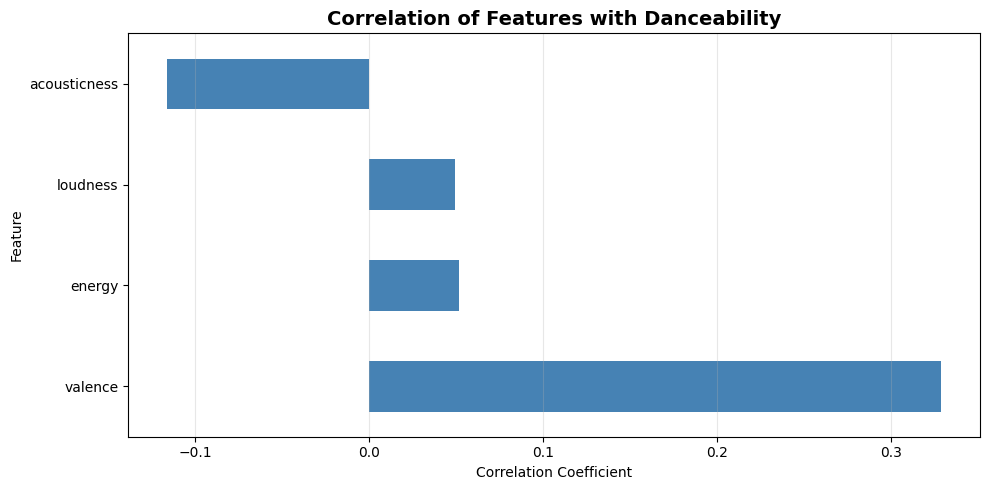

In [5]:
# Calculate correlation between predictors and target
correlations = df[key_features].corr()[target_feature].drop(target_feature).sort_values(ascending=False)

print("Correlation of each feature with Danceability:")
print("="*50)
for feature, corr in correlations.items():
    print(f"{feature:15s}: {corr:6.3f}")

# Visualize correlations
plt.figure(figsize=(10, 5))
correlations.plot(kind='barh', color='steelblue')
plt.title('Correlation of Features with Danceability', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [6]:
# Standardize features for fair comparison of coefficients
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data standardized for fair coefficient comparison")

Data standardized for fair coefficient comparison


## Feature Importance Analysis

Let's examine how each of the 4 predictor features contributes to predicting danceability by looking at the regression coefficients.

## Modelling

In [7]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Linear Regression Performance:")
print("="*50)
print(f"R²:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")

Linear Regression Performance:
R²:   0.1367
RMSE: 0.1297
MAE:  0.1028



Feature Importance (Standardized Coefficients):
     Feature  Coefficient
     valence     0.057915
      energy    -0.049923
acousticness    -0.023994
    loudness     0.018973


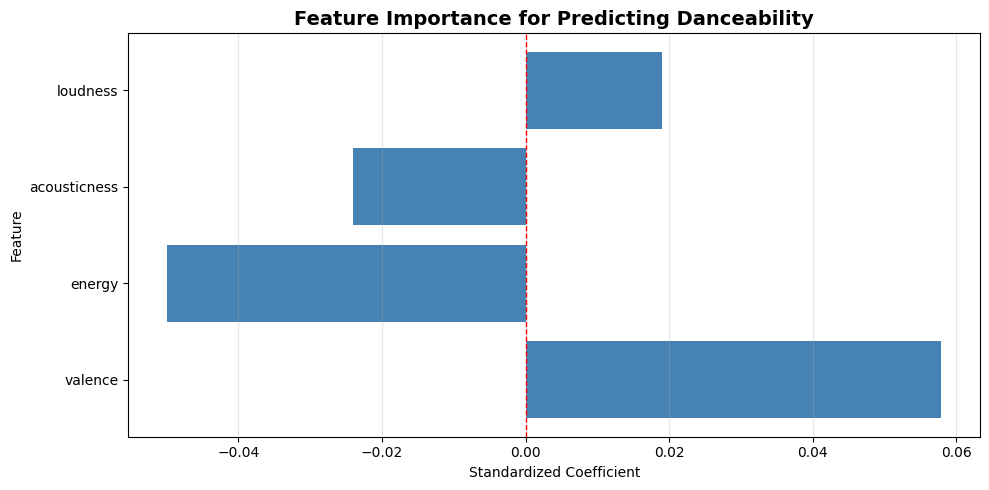

In [8]:
# Feature importance: regression coefficients (after standardization)
feature_importance = pd.DataFrame({
    'Feature': predictor_features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False, key=abs)

print("\nFeature Importance (Standardized Coefficients):")
print("="*50)
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='steelblue')
plt.title('Feature Importance for Predicting Danceability', fontsize=14, fontweight='bold')
plt.xlabel('Standardized Coefficient')
plt.ylabel('Feature')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

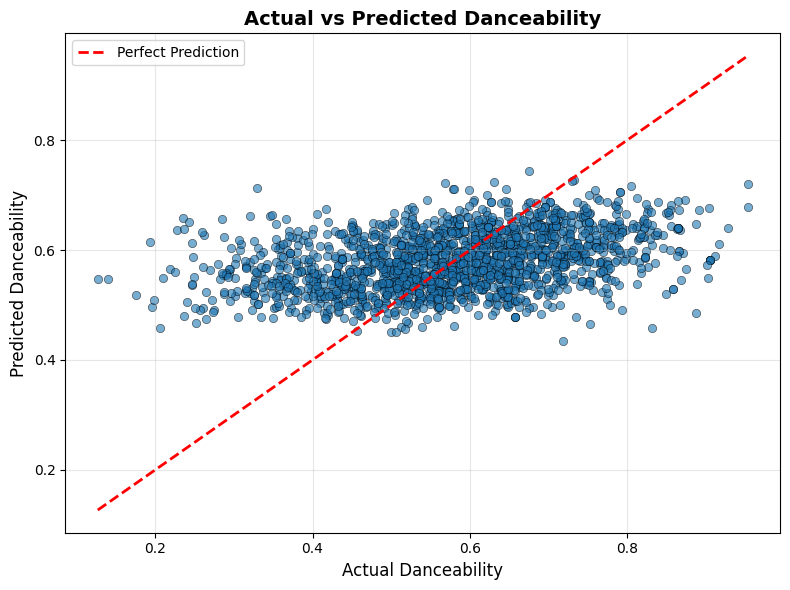

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='black', linewidths=0.5)
plt.xlabel("Actual Danceability", fontsize=12)
plt.ylabel("Predicted Danceability", fontsize=12)
plt.title("Actual vs Predicted Danceability", fontsize=14, fontweight='bold')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:** The model shows moderate performance, indicating that energy, acousticness, valence, and loudness provide some predictive power for danceability. The relationship may be non-linear, or other factors not captured by these audio features may also influence danceability.

## Regularization: Ridge regression

In [10]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge Regression Performance:")
print("="*50)
print(f"R²:   {r2_score(y_test, y_pred_ridge):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_ridge):.4f}")

Ridge Regression Performance:
R²:   0.1367
RMSE: 0.1297
MAE:  0.1028


In [11]:
plt.scatter(y_test, ridge_pred, alpha = 0.6)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Danceability")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

NameError: name 'ridge_pred' is not defined

| Model             | R^2       | RMSE      | MAE       |
| --------------    | :-------: | :-------: | :-------: |
| Linear regression | 0.3418    | 0.1133    | 0.0889    |
| Ridge regression  | 0.3417    | 0.1133    | 0.0889    |

There's no sign of improvement with ridge regression - in fact, the R^2 value is slightly less than linear regression. This is due to the fact that regularization penalizes complexity to prevent overfitting. Since the initial model was already simple, adding the penalty further restricted the model from fitting the data.